In [1]:
!nvidia-smi

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Wed Feb 22 15:58:18 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+--------------

In [2]:
!pip install -q segmentation_models

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [3]:
from glob import glob
import matplotlib.pyplot as plt
import cv2, os 
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
import os
from keras import backend as K 
from segmentation_models.losses import cce_jaccard_loss, dice_loss, JaccardLoss
from segmentation_models.metrics import iou_score, f1_score, precision, recall
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping

Segmentation Models: using `keras` framework.


In [4]:
len(glob("/kaggle/input/idd-20k/idd20k_final/train/labels/*")),len(glob("/kaggle/input/idd-20k/idd20k_final/valid/labels/*"))

(5966, 1016)

In [5]:
!rm -r Dataset

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
rm: cannot remove 'Dataset': No such file or directory


In [6]:
!mkdir /kaggle/working/Dataset
!mkdir /kaggle/working/Dataset/images
!mkdir /kaggle/working/Dataset/masks_org
!mkdir /kaggle/working/Dataset/masks

# !mkdir /kaggle/working/Dataset/IDD/Test
# !mkdir /kaggle/working/Dataset/IDD/Test/images
# !mkdir /kaggle/working/Dataset/IDD/Test/masks_org
# !mkdir /kaggle/working/Dataset/IDD/Test/masks

!cp /kaggle/input/idd-20k/idd20k_final/train/images/*  Dataset/images/
!cp /kaggle/input/idd-20k/idd20k_final/train/labels/*  Dataset/masks_org/

!cp /kaggle/input/idd-20k/idd20k_final/valid/images/*  Dataset/images/
!cp /kaggle/input/idd-20k/idd20k_final/valid/labels/*  Dataset/masks_org/

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [7]:
i = !ls /kaggle/working/Dataset/images/
l = !ls /kaggle/working/Dataset/masks_org/

len(i), len(l) 

(6797, 6797)

In [8]:
l[-5:], i[-5:]

(['frame9980.jpg',
  'frame9982.jpg',
  'frame9991.jpg',
  'frame9994.jpg',
  'frame99992.jpg'],
 ['frame9980.jpg',
  'frame9982.jpg',
  'frame9991.jpg',
  'frame9994.jpg',
  'frame99992.jpg'])

Dataset/masks_org/frame17477.jpg
(1080, 1920)
[  0   1   3   4   5   6   9  13  14  17  20  21  22  24  25 255]


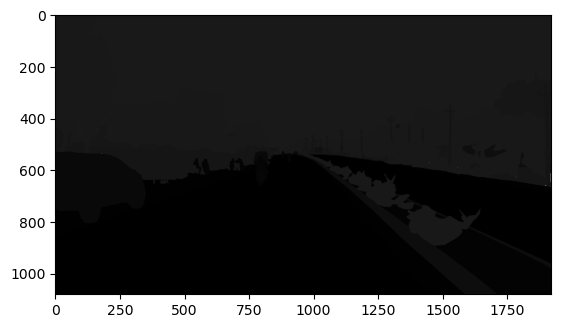

In [9]:
l = glob('Dataset/masks_org/*')
print(l[9])
m = cv2.imread(l[9],0)
print(m.shape)
print(np.unique(m))
plt.imshow(m,cmap="gray")
plt.show()

In [10]:
# 100 = background 
# 101 = road        
# 102 = obstacle   

def mask_mapping(path=''):
    for i, filepath in tqdm(enumerate(glob(path))):
        
        img = cv2.imread(filepath,0)    
        
        for j in [2,3,13,14,15,16,17,18,19,20,21,22,23,24,25,255]:
            img = np.where(img == j , 100, img)            
            
        for j in [4,5,6,7,8,9,10,11,12]:
            img = np.where(img == j , 102, img)

        for j in [0,1]:
            img = np.where(img == j , 101, img)
        
        img = img%100  
        splits_ = filepath.rsplit("/",2)
        filepath_ = splits_[0]+"/masks/"+ f"{splits_[2].split('.')[0]}.png"
        cv2.imwrite(filepath_, img)      
        lst= np.unique(img)
        if i<1 or not all(ii < 3 for ii in lst):
            print(np.unique(img))
            print(filepath_)

mask_mapping(path='Dataset/masks_org/*')

0it [00:00, ?it/s]

[0 1 2]
Dataset/masks/0004582.png


In [11]:
len(os.listdir('Dataset/images/'))

6796

In [12]:
len(os.listdir('Dataset/masks/'))

6796

  0%|          | 0/3 [00:00<?, ?it/s]

[0. 1. 2.]


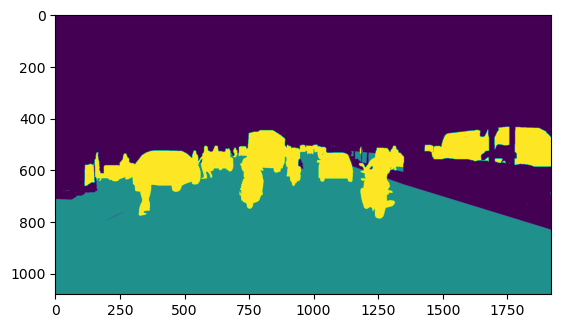

[0. 1. 2.]


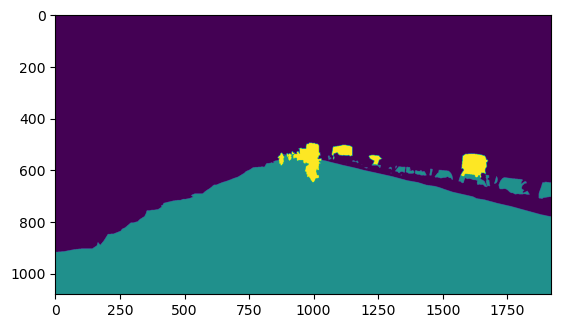

[0. 1. 2.]


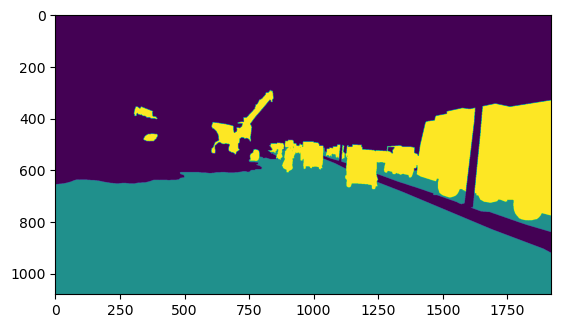

In [13]:
for i in tqdm(glob('Dataset/masks/*')[4:7]):
    t = cv2.imread(i,0)
    t = t.astype(np.float32)
    print(np.unique(t))
    plt.imshow(t)
    plt.show()

In [14]:
!rm -r Dataset/masks_org/

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [15]:
print(tf.__version__)
print(keras.__version__)

2.9.2
2.9.0


In [16]:
images = sorted(glob('/kaggle/working/Dataset/images/*'))
masks = sorted(glob('/kaggle/working/Dataset/masks/*'))
len(images), len(masks)

(6796, 6796)

In [17]:
for i in tqdm(masks):
  img = cv2.imread(i,0)
  img = cv2.resize(img, (256, 256), fx=0, fy=0, interpolation=cv2.INTER_NEAREST)
  print(np.unique(img))  
  break

  0%|          | 0/6796 [00:00<?, ?it/s]

[0 1 2]


In [25]:
def load_dataset(images, masks):
    
    train_x, test_x, train_y, test_y = train_test_split(images, masks, test_size=0.4, random_state=1996, shuffle=True)
    train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.15, random_state=1996, shuffle=True)
    
    return train_x, val_x, train_y, val_y, test_x, test_y

train_x, val_x, train_y, val_y, test_x, test_y = load_dataset(sorted(images), sorted(masks))
print(len(train_x), len(val_x), len(train_y), len(val_y), len(test_x), len(test_y))

train_X_y_paths = list(zip(train_x, train_y))
val_X_y_paths = list(zip(test_x, test_y))
test_X_y_paths = list(zip(val_x, val_y))

def get_data_generator(samples,batch_size):

  while True:

    for offset in range(0, len(samples), batch_size): 
      batch_samples = samples[offset:offset+batch_size]
      X_train = []
      Y_train = []        
 
      for batch_sample in batch_samples:
        
        s = np.random.randint(0,895)
#         img[1023,2047]
        
        X_image = cv2.imread(batch_sample[0])[:,:,::-1]
        X_image = X_image[56:,s:s+1024]
        X_image = X_image / 255.0
        X_image = cv2.resize(X_image, (256, 256))
        X_image = X_image.astype(np.float32)

        Y_image = cv2.imread(batch_sample[1], 0)
        Y_image = Y_image[56:,s:s+1024]
#         Y_image = Y_image / 255.0
        Y_image = cv2.resize(Y_image, (256, 256), fx=0, fy=0, interpolation=cv2.INTER_NEAREST)
        Y_image = tf.one_hot(Y_image, 3, dtype = np.float32)

        X_train.append(X_image)
        Y_train.append(Y_image)
 
      yield np.array(X_train), np.array(Y_train)


BATCH_SIZE = 24
train_generator = get_data_generator(train_X_y_paths,batch_size=BATCH_SIZE)
val_generator = get_data_generator(val_X_y_paths,batch_size=BATCH_SIZE)
test_generator = get_data_generator(test_X_y_paths,batch_size=BATCH_SIZE)

x_train, y_train = next(train_generator)
x_val, y_val  = next(val_generator)
x_test, y_test  = next(test_generator)

print(x_train.shape,y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

3465 612 3465 612 2719 2719
(24, 256, 256, 3) (24, 256, 256, 3)
(24, 256, 256, 3) (24, 256, 256, 3)
(24, 256, 256, 3) (24, 256, 256, 3)


In [26]:
np.unique(next(train_generator)[1])

array([0., 1.], dtype=float32)

In [27]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf
import keras
# import keras.backend as K
from keras.layers import Conv2D, BatchNormalization, Activation, Input, UpSampling2D, Concatenate, UpSampling2D
from keras.models import Model


print(tf.__version__)       
print(keras.__version__)    


def Conv_Block(inputs, n_filters):

  y = Conv2D(filters=n_filters, kernel_size=3, strides=1, padding='same', use_bias=False)(inputs)
  y = BatchNormalization()(y)
  y = Activation('relu')(y)

  return y


def Strided_Conv_Block(inputs, n_filters, n_stride):

  y = Conv2D(filters=n_filters, kernel_size=3, strides=2, padding='same', use_bias=False)(inputs)
  y = BatchNormalization()(y)
  y = Activation('relu')(y)

  return y


def Multi_Resolution_Parallel_Convolution(inputs, n_filters):

  y = Conv_Block(inputs, n_filters)
  y = Conv_Block(y, n_filters)
  y = Conv_Block(y, n_filters)
  y = Conv_Block(y, n_filters)

  return y


def Multi_Resolution_Fusion1(stage1_in, stage2_in, stage3_in, n_filters):

  stage2_i = Strided_Conv_Block(stage1_in, 2*n_filters, n_stride=2)
  stage2_ii = Strided_Conv_Block(stage2_i, 4*n_filters, n_stride=2)
  stage3 = Concatenate()([stage3_in, stage2_ii])
  stage3 = Conv2D(filters=4*n_filters, kernel_size=1, strides=1, padding='same', use_bias=False)(stage3)
  stage3 = BatchNormalization()(stage3)
  stage3 = Activation('relu')(stage3)


  stage2 = Concatenate()([stage2_in, stage2_i])
  stage2 = Conv2D(filters=2*n_filters, kernel_size=1, strides=1, padding='same', use_bias=False)(stage2)
  stage2 = BatchNormalization()(stage2)
  stage2 = Activation('relu')(stage2)


  stage1_i = UpSampling2D(size=2, interpolation='bilinear')(stage2_in)
  stage1 = Concatenate()([stage1_in, stage1_i])
  stage1 = Conv2D(filters=n_filters, kernel_size=1, strides=1, padding='same', use_bias=False)(stage1)
  stage1 = BatchNormalization()(stage1)
  stage1 = Activation('relu')(stage1)

  return stage1, stage2, stage3


def Multi_Resolution_Fusion2(stage1_in, stage2_in, stage3_in, stage4_in, n_filters):

  stage4_i = Strided_Conv_Block(stage1_in, 2*n_filters, n_stride=2)
  stage4_ii = Strided_Conv_Block(stage4_i, 4*n_filters, n_stride=2)
  stage4_iii = Strided_Conv_Block(stage4_ii, 8*n_filters, n_stride=2)

  stage4_iii_i = Strided_Conv_Block(stage2_in, 4*n_filters, n_stride=2)
  stage4_iii_ii = Strided_Conv_Block(stage4_iii_i, 8*n_filters, n_stride=2)

  stage4 = Concatenate()([stage4_in, stage4_iii, stage4_iii_ii])
  stage4 = Conv2D(filters=8*n_filters, kernel_size=1, strides=1, padding='same', use_bias=False)(stage4)
  stage4 = BatchNormalization()(stage4)
  stage4 = Activation('relu')(stage4)


  stage3 = Concatenate()([stage3_in, stage4_ii, stage4_iii_i])
  stage3 = Conv2D(filters=4*n_filters, kernel_size=1, strides=1, padding='same', use_bias=False)(stage3)
  stage3 = BatchNormalization()(stage3)
  stage3 = Activation('relu')(stage3)


  stage2_i = UpSampling2D(size=2, interpolation='bilinear')(stage3_in)
  stage2 = Concatenate()([stage2_in, stage4_i, stage2_i])
  stage2 = Conv2D(filters=2*n_filters, kernel_size=1, strides=1, padding='same', use_bias=False)(stage2)
  stage2 = BatchNormalization()(stage2)
  stage2 = Activation('relu')(stage2)


  stage1_i = UpSampling2D(size=2, interpolation='bilinear')(stage2_in)
  stage1_ii = UpSampling2D(size=4, interpolation='bilinear')(stage3_in)
  stage1 = Concatenate()([stage1_in, stage1_i, stage1_ii])
  stage1 = Conv2D(filters=n_filters, kernel_size=1, strides=1, padding='same', use_bias=False)(stage1)
  stage1 = BatchNormalization()(stage1)
  stage1 = Activation('relu')(stage1)

  return stage1, stage2, stage3, stage4


def Multi_Resolution_Fusion3(stage1_in, stage2_in, stage3_in, stage4_in, n_filters):

  stage4_i = Strided_Conv_Block(stage1_in, 2*n_filters, n_stride=2)
  stage4_ii = Strided_Conv_Block(stage4_i, 4*n_filters, n_stride=2)
  stage4_iii = Strided_Conv_Block(stage4_ii, 8*n_filters, n_stride=2)

  stage4_iii_i = Strided_Conv_Block(stage2_in, 4*n_filters, n_stride=2)
  stage4_iii_ii = Strided_Conv_Block(stage4_iii_i, 8*n_filters, n_stride=2)

  stage4_iii_ii_i = Strided_Conv_Block(stage3_in, 8*n_filters, n_stride=2)

  stage4 = Concatenate()([stage4_in, stage4_iii, stage4_iii_ii, stage4_iii_ii_i])
  stage4 = Conv2D(filters=8*n_filters, kernel_size=1, strides=1, padding='same', use_bias=False)(stage4)
  stage4 = BatchNormalization()(stage4)
  stage4 = Activation('relu')(stage4)


  stage3_i = UpSampling2D(size=2, interpolation='bilinear')(stage4_in)
  stage3 = Concatenate()([stage3_in, stage4_ii, stage4_iii_i, stage3_i])
  stage3 = Conv2D(filters=4*n_filters, kernel_size=1, strides=1, padding='same', use_bias=False)(stage3)
  stage3 = BatchNormalization()(stage3)
  stage3 = Activation('relu')(stage3)


  stage2_i = UpSampling2D(size=2, interpolation='bilinear')(stage3_in)
  stage2_ii = UpSampling2D(size=4, interpolation='bilinear')(stage4_in)
  stage2 = Concatenate()([stage2_in, stage4_i, stage2_i, stage2_ii])
  stage2 = Conv2D(filters=2*n_filters, kernel_size=1, strides=1, padding='same', use_bias=False)(stage2)
  stage2 = BatchNormalization()(stage2)
  stage2 = Activation('relu')(stage2)


  stage1_i = UpSampling2D(size=2, interpolation='bilinear')(stage2_in)
  stage1_ii = UpSampling2D(size=4, interpolation='bilinear')(stage3_in)
  stage1_iii = UpSampling2D(size=8, interpolation='bilinear')(stage4_in)
  stage1 = Concatenate()([stage1_in, stage1_i, stage1_ii, stage1_iii])
  stage1 = Conv2D(filters=n_filters, kernel_size=1, strides=1, padding='same', use_bias=False)(stage1)
  stage1 = BatchNormalization()(stage1)
  stage1 = Activation('relu')(stage1)

  return stage1, stage2, stage3, stage4


def HRNet(inputs, n_filters):

  # inputs = Input(input_shape)

  stage1 = Multi_Resolution_Parallel_Convolution(inputs, n_filters)
  stage2 = Strided_Conv_Block(stage1, 2*n_filters, n_stride=2)

  stage1 = Conv_Block(stage1, n_filters)
  stage1 = Multi_Resolution_Parallel_Convolution(stage1, n_filters) 
  stage2 = Multi_Resolution_Parallel_Convolution(stage2, 2*n_filters)
  stage3 = Strided_Conv_Block(stage2, 4*n_filters, n_stride=2)

  stage1, stage2, stage3 = Multi_Resolution_Fusion1(stage1, stage2, stage3, n_filters)
  stage1 = Multi_Resolution_Parallel_Convolution(stage1, n_filters)
  stage2 = Multi_Resolution_Parallel_Convolution(stage2, 2*n_filters)
  stage3 = Multi_Resolution_Parallel_Convolution(stage3, 4*n_filters)
  stage4 = Strided_Conv_Block(stage3, 8*n_filters, n_stride=2)

  stage1, stage2, stage3, stage4 = Multi_Resolution_Fusion2(stage1, stage2, stage3, stage4, n_filters)
  stage1 = Multi_Resolution_Parallel_Convolution(stage1, n_filters)
  stage2 = Multi_Resolution_Parallel_Convolution(stage2, 2*n_filters)
  stage3 = Multi_Resolution_Parallel_Convolution(stage3, 4*n_filters)
  stage4 = Multi_Resolution_Parallel_Convolution(stage4, 8*n_filters)
  stage1, stage2, stage3, stage4 = Multi_Resolution_Fusion3(stage1, stage2, stage3, stage4, n_filters)
  # print(stage1.shape, stage2.shape, stage3.shape, stage4.shape)
  
  return stage1, stage2, stage3, stage4


def HRNet_Segmentation(input_shape, n_classes, n_filters):

  inputs = Input(input_shape)

  stage1, stage2, stage3, stage4 = HRNet(inputs, n_filters=n_filters)

  stage2 = UpSampling2D(size=2, interpolation='bilinear')(stage2)
  stage3 = UpSampling2D(size=4, interpolation='bilinear')(stage3)
  stage4 = UpSampling2D(size=8, interpolation='bilinear')(stage4)
  
  y = Concatenate()([stage1, stage2, stage3, stage4])

  y = Conv2D(filters=2*n_filters, kernel_size=1, strides=1, padding='same', use_bias=False)(y)
  y = BatchNormalization()(y)
  y = Activation('relu')(y)

  y = Conv2D(filters=n_classes, kernel_size=1, strides=1, padding='same', use_bias=False)(y)

  if n_classes == 1:
    y = Activation('sigmoid')(y)
  else:
    y = Activation('softmax')(y)
  # print(y.shape)

  model = Model(inputs=inputs, outputs=y)

  return model


# model = HRNet_Segmentation(input_shape=(256,256,3), n_classes=3, n_filters=16)

2.9.2
2.9.0


In [28]:
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
%env SM_FRAMEWORK=tf.keras


""" Paramaters """
input_shape = (256, 256, 3)
epochs = 1000
lr = 1e-1
csv_path = "/kaggle/working/history.csv"
# model_name = 'HRNet'
n_classes = 3


""" callbacks """
checkpoint_filepath = '/kaggle/working/IDD_Seg_HRNet_00{epoch}.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_iou_score',
    mode='max',
    verbose = 1,
    period = 3,
    save_best_only=False
    )

callbacks = [
    model_checkpoint_callback,
    ReduceLROnPlateau(monitor="val_loss", patience=4, factor=0.5, verbose=1),
    CSVLogger(csv_path),
    EarlyStopping(monitor="val_loss", patience=10)
]


""" steps per epochs """
train_steps = len(train_x)//BATCH_SIZE
if len(train_x) % BATCH_SIZE != 0:
    train_steps += 1

val_steps = len(val_x)//BATCH_SIZE
if len(val_x) % BATCH_SIZE != 0:
    val_steps += 1

print(train_steps, val_steps)


""" Model training """
ls = dice_loss + cce_jaccard_loss
metrics = [precision, recall, f1_score, iou_score] 

K.clear_session()
model = HRNet_Segmentation(input_shape=input_shape, n_classes=n_classes, n_filters=12)
model.load_weights('/kaggle/working/IDD_Seg_HRNet_006.h5')
# if model_name == 'DeepLabV3Plus': 
#   model = DeepLabV3Plus(inputs=input_shape, classes=n_classes)
# elif model_name == 'PSPNet': 
#   model = PSPNet(inputs=input_shape, classes=n_classes)
# model.summary()

model.compile(
    loss=ls,
    optimizer=tf.keras.optimizers.SGD(learning_rate=lr),
    metrics=metrics
)

h = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    steps_per_epoch=train_steps//5,
    validation_steps=val_steps//5,
    callbacks=callbacks,
    batch_size=BATCH_SIZE,
    workers=-1,
    use_multiprocessing=True,
)

model.save('/kaggle/working/IDD_Seg_HRNet_last.h5')

env: SM_FRAMEWORK=tf.keras
145 26
Epoch 1/1000


2023-02-22 16:28:58.195165: W tensorflow/core/kernels/gpu_utils.cc:50] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.


29/29 [==============================] - 98s 3s/step - loss: 1.1450 - precision: 0.5886 - recall: 0.6059 - f1-score: 0.5894 - iou_score: 0.4631 - val_loss: 1.8844 - val_precision: 0.3341 - val_recall: 0.3339 - val_f1-score: 0.3039 - val_iou_score: 0.1867 - lr: 0.1000
Epoch 2/1000
29/29 [==============================] - 86s 3s/step - loss: 0.8213 - precision: 0.7124 - recall: 0.7343 - f1-score: 0.7184 - iou_score: 0.6006 - val_loss: 2.0709 - val_precision: 0.3374 - val_recall: 0.3349 - val_f1-score: 0.2600 - val_iou_score: 0.1645 - lr: 0.1000
Epoch 3/1000
29/29 [==============================] - ETA: 0s - loss: 0.7519 - precision: 0.7417 - recall: 0.7619 - f1-score: 0.7477 - iou_score: 0.6333
Epoch 3: saving model to /kaggle/working/IDD_Seg_HRNet_003.h5
29/29 [==============================] - 86s 3s/step - loss: 0.7519 - precision: 0.7417 - recall: 0.7619 - f1-score: 0.7477 - iou_score: 0.6333 - val_loss: 2.2257 - val_precision: 0.3788 - val_recall: 0.3432 - val_f1-score: 0.2374 - val

2023-02-22 17:12:26.965945: W tensorflow/core/framework/op_kernel.cc:1733] INVALID_ARGUMENT: ValueError: Could not find callback with key=pyfunc_5 in the registry.
Traceback (most recent call last):

  File "/opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/script_ops.py", line 258, in __call__
    raise ValueError(f"Could not find callback with key={token} in the "

ValueError: Could not find callback with key=pyfunc_5 in the registry.


2023-02-22 17:12:26.966425: W tensorflow/core/kernels/data/generator_dataset_op.cc:108] Error occurred when finalizing GeneratorDataset iterator: INVALID_ARGUMENT: ValueError: Could not find callback with key=pyfunc_5 in the registry.
Traceback (most recent call last):

  File "/opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/script_ops.py", line 258, in __call__
    raise ValueError(f"Could not find callback with key={token} in the "

ValueError: Could not find callback with key=pyfunc_5 in the registry.


	 [[{{node PyFunc}}]]

29/29 [==============================] - 85s 3s/step - loss: 0.4163 - precision: 0.8729 - recall: 0.8776 - f1-score: 0.8733 - iou_score: 0.7896 - val_loss: 0.3950 - val_precision: 0.8662 - val_recall: 0.8909 - val_f1-score: 0.8773 - val_iou_score: 0.7955 - lr: 0.0250
Epoch 31/1000
29/29 [==============================] - 87s 3s/step - loss: 0.4137 - precision: 0.8727 - recall: 0.8779 - f1-score: 0.8734 - iou_score: 0.7900 - val_loss: 0.7361 - val_precision: 0.8852 - val_recall: 0.7230 - val_f1-score: 0.7567 - val_iou_score: 0.6628 - lr: 0.0250
Epoch 32/1000
29/29 [==============================] - 87s 3s/step - loss: 0.4105 - precision: 0.8746 - recall: 0.8779 - f1-score: 0.8750 - iou_score: 0.7919 - val_loss: 0.4020 - val_precision: 0.8896 - val_recall: 0.8651 - val_f1-score: 0.8757 - val_iou_score: 0.7942 - lr: 0.0250
Epoch 33/1000
29/29 [==============================] - ETA: 0s - loss: 0.4054 - precision: 0.8755 - recall: 0.8793 - f1-score: 0.8761 - iou_score: 0.7936
Epoch 33: savi

In [31]:
history = pd.read_csv('/kaggle/working/history.csv')

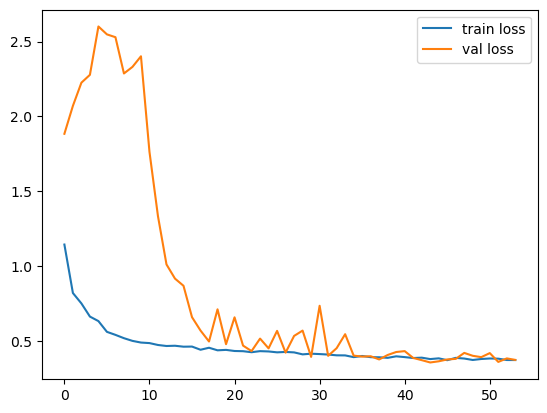

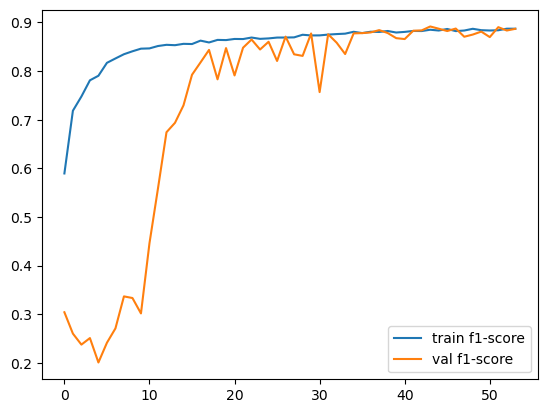

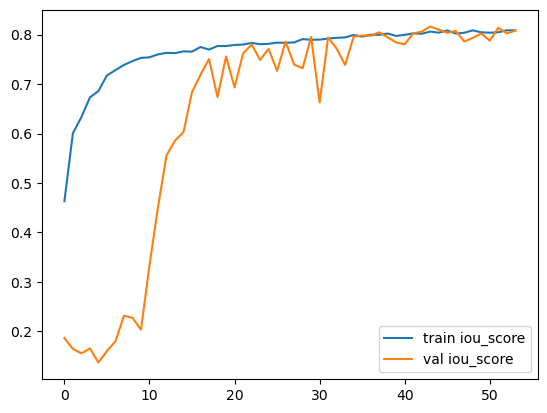

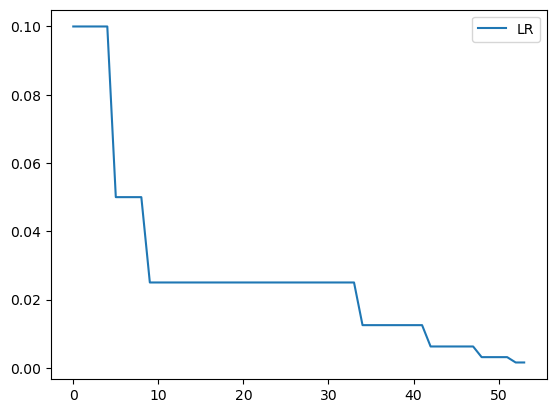

In [32]:
# print(h.history.keys(),"\n")

plt.plot(history['loss'], label='train loss')
plt.plot(history['val_loss'], label='val loss')
plt.legend()
plt.show()

plt.plot(history['f1-score'], label='train f1-score')
plt.plot(history['val_f1-score'], label='val f1-score')
plt.legend()
plt.show()

plt.plot(history['iou_score'], label='train iou_score')
plt.plot(history['val_iou_score'], label='val iou_score')
plt.legend()
plt.show()

plt.plot(history['lr'], label='LR')
plt.legend()
plt.show()

In [ ]:
# input_shape = (256, 256, 3)
# n_classes = 3
# lr = 0.1
# ls = dice_loss + cce_jaccard_loss
# metrics = [precision, recall, f1_score, iou_score] 

# model = HRNet_Segmentation(input_shape=input_shape, n_classes=n_classes, n_filters=12)
# model.load_weights('/kaggle/working/IDD_Seg_HRNet_last.h5')

# model.compile(
#     loss=ls,
#     optimizer=tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9),
#     metrics=metrics
# )

In [33]:
test_steps = len(test_x)//BATCH_SIZE
if len(test_x) % BATCH_SIZE != 0:
    test_steps += 1
    
print(test_steps)    

model.evaluate(test_generator, batch_size=BATCH_SIZE, steps=test_steps, workers=-1, use_multiprocessing=True)

114
114/114 [==============================] - 198s 2s/step - loss: 0.3699 - precision: 0.8884 - recall: 0.8892 - f1-score: 0.8883 - iou_score: 0.8106


[0.36994168162345886,
 0.8884485363960266,
 0.8892328143119812,
 0.8883247375488281,
 0.8105717897415161]

In [34]:
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
%env SM_FRAMEWORK=tf.keras


""" Paramaters """
input_shape = (256, 256, 3)
epochs = 1000
lr = 1e-3
csv_path = "/kaggle/working/history2.csv"
# model_name = 'HRNet'
n_classes = 3


""" callbacks """
checkpoint_filepath = '/kaggle/working/IDD_Seg_HRNet_00{epoch}.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_iou_score',
    mode='max',
    verbose = 1,
    period = 3,
    save_best_only=False
    )

callbacks = [
    model_checkpoint_callback,
    ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.5, verbose=1),
    CSVLogger(csv_path),
    EarlyStopping(monitor="val_loss", patience=7)
]


""" steps per epochs """
train_steps = len(train_x)//BATCH_SIZE
if len(train_x) % BATCH_SIZE != 0:
    train_steps += 1

val_steps = len(val_x)//BATCH_SIZE
if len(val_x) % BATCH_SIZE != 0:
    val_steps += 1

print(train_steps, val_steps)


""" Model training """
ls = dice_loss + cce_jaccard_loss
metrics = [precision, recall, f1_score, iou_score] 

# K.clear_session()
# model = HRNet_Segmentation(input_shape=input_shape, n_classes=n_classes, n_filters=12)
# model.load_weights('/kaggle/working/IDD_Seg_HRNet_006.h5')
# if model_name == 'DeepLabV3Plus': 
#   model = DeepLabV3Plus(inputs=input_shape, classes=n_classes)
# elif model_name == 'PSPNet': 
#   model = PSPNet(inputs=input_shape, classes=n_classes)
# model.summary()

model.compile(
    loss=ls,
    optimizer=tf.keras.optimizers.SGD(learning_rate=lr),
    metrics=metrics
)

h = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    steps_per_epoch=train_steps,
    validation_steps=val_steps,
    callbacks=callbacks,
    batch_size=BATCH_SIZE,
    workers=-1,
    use_multiprocessing=True,
    initial_epoch=55
)

model.save('/kaggle/working/IDD_Seg_HRNet_last.h5')

env: SM_FRAMEWORK=tf.keras
145 26
Epoch 56/1000
145/145 [==============================] - 441s 3s/step - loss: 0.3764 - precision: 0.8862 - recall: 0.8878 - f1-score: 0.8858 - iou_score: 0.8074 - val_loss: 0.3731 - val_precision: 0.8878 - val_recall: 0.8870 - val_f1-score: 0.8867 - val_iou_score: 0.8088 - lr: 0.0010
Epoch 57/1000
145/145 [==============================] - 436s 3s/step - loss: 0.3754 - precision: 0.8862 - recall: 0.8885 - f1-score: 0.8862 - iou_score: 0.8079 - val_loss: 0.3687 - val_precision: 0.8843 - val_recall: 0.8924 - val_f1-score: 0.8879 - val_iou_score: 0.8106 - lr: 0.0010
Epoch 58/1000
145/145 [==============================] - ETA: 0s - loss: 0.3734 - precision: 0.8875 - recall: 0.8886 - f1-score: 0.8869 - iou_score: 0.8089
Epoch 58: saving model to /kaggle/working/IDD_Seg_HRNet_0058.h5
145/145 [==============================] - 433s 3s/step - loss: 0.3734 - precision: 0.8875 - recall: 0.8886 - f1-score: 0.8869 - iou_score: 0.8089 - val_loss: 0.3816 - val_prec

In [43]:
history = pd.read_csv('/kaggle/working/history2.csv')

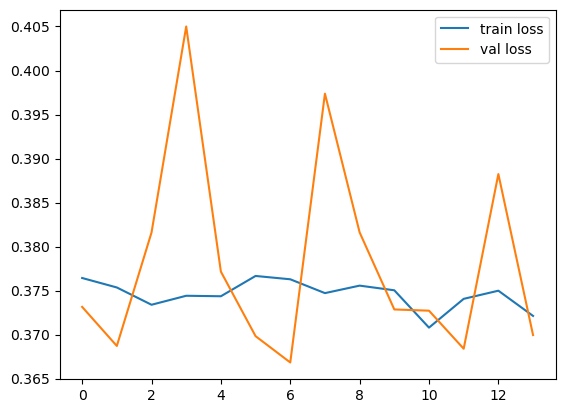

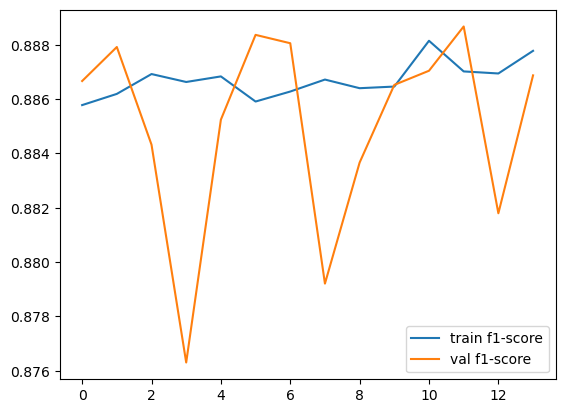

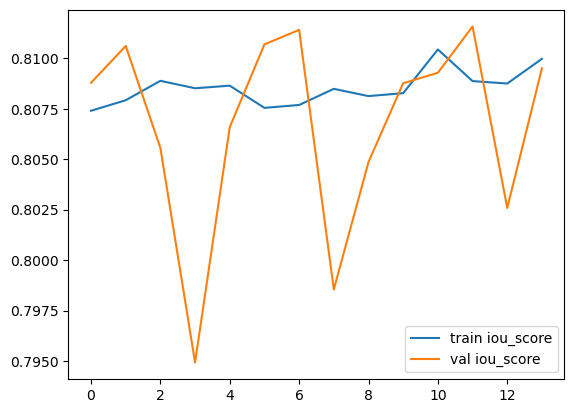

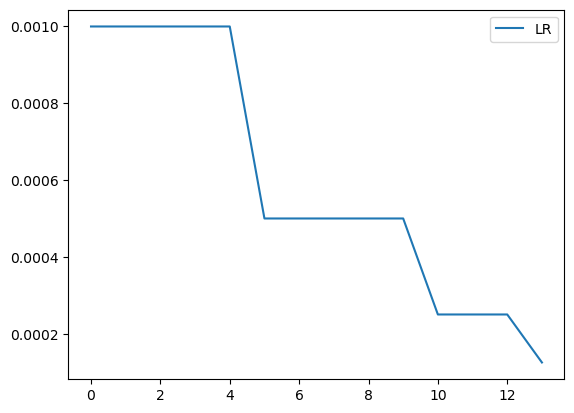

In [44]:
# print(h.history.keys(),"\n")

plt.plot(history['loss'], label='train loss')
plt.plot(history['val_loss'], label='val loss')
plt.legend()
plt.show()

plt.plot(history['f1-score'], label='train f1-score')
plt.plot(history['val_f1-score'], label='val f1-score')
plt.legend()
plt.show()

plt.plot(history['iou_score'], label='train iou_score')
plt.plot(history['val_iou_score'], label='val iou_score')
plt.legend()
plt.show()

plt.plot(history['lr'], label='LR')
plt.legend()
plt.show()

In [45]:
# input_shape = (256, 256, 3)
# n_classes = 3
# lr = 0.1
# ls = dice_loss + cce_jaccard_loss
# metrics = [precision, recall, f1_score, iou_score] 

# model = HRNet_Segmentation(input_shape=input_shape, n_classes=n_classes, n_filters=12)
# model.load_weights('/kaggle/working/IDD_Seg_HRNet_last.h5')

# model.compile(
#     loss=ls,
#     optimizer=tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9),
#     metrics=metrics
# )

In [46]:
test_steps = len(test_x)//BATCH_SIZE
if len(test_x) % BATCH_SIZE != 0:
    test_steps += 1
    
print(test_steps)    

model.evaluate(test_generator, batch_size=BATCH_SIZE, steps=test_steps, workers=-1, use_multiprocessing=True)

114
114/114 [==============================] - 199s 2s/step - loss: 0.3658 - precision: 0.8917 - recall: 0.8895 - f1-score: 0.8900 - iou_score: 0.8129


[0.3657967150211334,
 0.8916652798652649,
 0.8895014524459839,
 0.8900288939476013,
 0.8128923773765564]